## Analysis for paper writing
Author: Sahar H. El Abbadi
Date: 2023-04-12


## Flight Altitude Calculations
Use "altitude_feet" column in overpass summary files


In [1]:

from methods_source import load_overpass_summary, feet_per_meter

operators = ['Carbon Mapper', 'GHGSat', 'Kairos', 'MethaneAIR']
op_alt = {}
feet_per_meter = feet_per_meter()
for operator in operators:
    overpasses = load_overpass_summary(operator=operator, stage=1, strict_discard=False, time_ave=60, gas_comp_source='ms')
    altitude = overpasses.altitude_feet
    altitude_meters = altitude / feet_per_meter
    op_alt[operator] = {
        'average_meters': altitude_meters.mean(),
        'average_feet': altitude.mean(),
        'min_meters': altitude_meters.min(),
        'min_feet': altitude.min(),
        'max_meters': altitude_meters.max(),
        'max_feet': altitude.max()
    }

print('Average, minimum, and maximum overpass altitudes across all reported overpasses:\n')
for operator in operators:
    data = op_alt[operator]
    print(f'{operator}:')
    print(f' Average Altitude: {data["average_meters"]:,.1f} meters ({data["average_feet"]:,.1f} ft)')
    print(f' Min Altitude: {data["min_meters"]:,.1f} meters ({data["min_feet"]:,.1f} ft)')
    print(f' Max Altitude: {data["max_meters"]:,.1f} meters ({data["max_feet"]:,.1f} ft)')
    print()



Average, minimum, and maximum overpass altitudes across all reported overpasses:

Carbon Mapper:
 Average Altitude: 3,152.1 meters (10,341.6 ft)
 Min Altitude: 3,050.4 meters (10,007.9 ft)
 Max Altitude: 3,228.5 meters (10,592.2 ft)

GHGSat:
 Average Altitude: 2,010.1 meters (6,594.9 ft)
 Min Altitude: 1,927.5 meters (6,323.8 ft)
 Max Altitude: 2,083.5 meters (6,835.6 ft)

Kairos:
 Average Altitude: 411.9 meters (1,351.4 ft)
 Min Altitude: 368.3 meters (1,208.2 ft)
 Max Altitude: 538.4 meters (1,766.3 ft)

MethaneAIR:
 Average Altitude: 13,286.7 meters (43,591.6 ft)
 Min Altitude: 12,687.0 meters (41,624.0 ft)
 Max Altitude: 13,614.7 meters (44,667.5 ft)


In [2]:
### Calculate average flight for each day of testing
from methods_source import calc_daily_altitude, feet_per_meter

feet_per_meter = feet_per_meter()

def print_daily_altitude(operator):
    alt = calc_daily_altitude(operator)
    print(f'{operator} average daily altitude:')
    for date, altitude_feet in alt.iterrows():
        altitude_meters = altitude_feet / feet_per_meter
        print(f'{date}: {altitude_feet["altitude_feet"]:,.1f} feet / {altitude_meters[0]:,.1f} meters')

operators = ['Carbon Mapper', 'GHGSat', 'Kairos', 'Methane Air']
for operator in operators:
    print_daily_altitude(operator)
    print('\n')

Carbon Mapper average daily altitude:
2022-10-10: 10,372.2 feet / 3,161.4 meters
2022-10-11: 10,327.0 feet / 3,147.7 meters
2022-10-12: 10,218.8 feet / 3,114.7 meters
2022-10-28: 10,182.4 feet / 3,103.6 meters
2022-10-29: 10,373.5 feet / 3,161.8 meters
2022-10-31: 10,519.8 feet / 3,206.4 meters


GHGSat average daily altitude:
2022-10-31: 6,565.1 feet / 2,001.0 meters
2022-11-02: 6,561.0 feet / 1,999.8 meters
2022-11-04: 6,575.5 feet / 2,004.2 meters
2022-11-07: 6,694.1 feet / 2,040.3 meters


Kairos average daily altitude:
2022-10-24: 1,334.4 feet / 406.7 meters
2022-10-25: 1,317.9 feet / 401.7 meters
2022-10-26: 1,328.9 feet / 405.0 meters
2022-10-27: 1,389.3 feet / 423.5 meters
2022-10-28: 1,385.6 feet / 422.3 meters


Methane Air average daily altitude:
2022-10-25: 43,367.8 feet / 13,218.5 meters
2022-10-29: 43,780.9 feet / 13,344.4 meters


## Summarize distribution of overpasses

Total number of overpasses, missing data, max and min given to each team, number that passed Stanford QC

Missing overpasses: documented as an overpass by Stanford, but not included in Operator Report file

In [3]:
# All releases conducted
from methods_source import load_overpass_summary, find_missing_data, abbreviate_op_name
import pandas as pd

def summarize_releases(operator, strict_discard=False):
    op_summary = load_overpass_summary(operator, stage=1, strict_discard=strict_discard)
    operator_missing = len(find_missing_data(operator))
    operator_releases = len(op_summary) + operator_missing
    operator_pass_su = len(op_summary.loc[op_summary.stanford_kept == True])
    operator_fail_su = len(op_summary.loc[op_summary.stanford_kept == False])
    op_ab = abbreviate_op_name(operator)
    summary = {
        f'operator': op_ab,
        f'releases': operator_releases,
        f'pass_su': operator_pass_su,
        f'fail_su': operator_fail_su,
        f'missing': operator_missing,
    }
    return summary


cm = summarize_releases('Carbon Mapper')
ghg = summarize_releases('GHGSat')
kairos = summarize_releases('Kairos')
mair = summarize_releases('MethaneAIR')
sciav = summarize_releases('Scientific Aviation', True)
dicts = [cm, ghg, kairos, mair, sciav]

# Combine all dictionaries into one
summary = {key: [d[key] for d in dicts] for key in dicts[0]}

# Convert to DataFrame:
summary = pd.DataFrame.from_records(summary)
print(summary.sum(axis=0))

fail_su                      189
missing                        7
operator    cmghgkairosmairsciav
pass_su                      515
releases                     711
dtype: object


## Determine overpass time

Determine average time for each overpass

In [4]:
from methods_source import load_operator_flight_days, load_overpass_summary, abbreviate_op_name
import pandas as pd

def calc_average_overpass_time(operator):
    op_ab = abbreviate_op_name(operator)
    op_overpasses = load_overpass_summary(operator, 1)
    op_days = load_operator_flight_days(operator)

    # Set overpass_datetime to index for easier filtering. First save a copy of datetime so I have a column that is not an index
    op_overpasses['datetime_copy'] = op_overpasses['overpass_datetime']
    op_datetime_index = op_overpasses.set_index('overpass_datetime')

    # Set up dictionary for storing data
    timestamps = pd.Series(dtype='float64')
    if op_ab == 'sciav':
        measurement_time = op_overpasses['overpass_datetime_end'] - op_overpasses['datetime_copy']
        timestamps = measurement_time
    else:
        # iterate through operator flight days (Note: _ represents index)
        for _, flight_day in op_days.iterrows():
            # Iterate through each flight day
            start_time = flight_day['start_time']
            flight_day_str = start_time.strftime('%Y-%m-%d')
            daily_overpasses = op_datetime_index.loc[flight_day_str]

            # Calculate time differences
            delta_t = daily_overpasses['datetime_copy'].diff()
            timestamps = pd.concat([timestamps, delta_t])

    average_overpass_time = timestamps.mean()
    overpass_minutes = str(average_overpass_time)[10:15]
    print(f'{operator} average overpass time is {overpass_minutes} minutes')
    return

calc_average_overpass_time('Carbon Mapper')
calc_average_overpass_time('GHGSat')
calc_average_overpass_time('Kairos')
calc_average_overpass_time('MethaneAIR')
calc_average_overpass_time('Scientific Aviation')


Carbon Mapper average overpass time is 12:21 minutes
GHGSat average overpass time is 03:48 minutes
Kairos average overpass time is 03:14 minutes
MethaneAIR average overpass time is 22:13 minutes
Scientific Aviation average overpass time is 20:34 minutes


#### Carbon Mapper overpass summary for results

In [5]:
from writing_analysis import operator_releases_summary_stats
# Carbon Mapper
operator = 'Carbon Mapper'
operator_releases_summary_stats(operator)

Carbon Mapper: 121 flightlines reported to SU
8 overpasses that fail SU QC
113 overpasses that pass SU QC
82 overpasses quantified by Carbon Mapper
31 overpasses removed by Carbon Mapper

3 overpasses documented by Stanford but not reported by Carbon Mapper

Total releases conducted by Stanford (including missing overpasses not reported by Carbon Mapper: 124

Smallest non-zero volume overpass for Carbon Mapper that passes SU qc:
Release Rate: 4.4451804176775 kg CH4 / hr
[4.301638947741193, 4.588721887613808, 95% CI]
(sigma from gas flow: 0.067039)
(sigma from meter: 0.039443)
(sigma from gas composition: 0.001617)
(combined total sigma: 0.073235)

Smallest non-zero volume overpass for Carbon Mapper that passes operator and SU qc:
Release Rate: 4.4451804176775 kg CH4 / hr
[4.301638947741193, 4.588721887613808, 95% CI]
(sigma from gas flow: 0.067039)
(sigma from meter: 0.039443)
(sigma from gas composition: 0.001617)
(combined total sigma: 0.073235)

Largest volume overpass for Carbon Ma

## Carbon Mapper detection notes

Carbon Mapper applied a QC filter for quantification, but they report detection even where they were not confident in quantification.

Here, I determine the smallest release that they detected, considering points that fail their quantification QC.

In [6]:
from methods_source import load_overpass_summary, classify_confusion_categories
from writing_analysis import print_overpass_info

operator = 'Carbon Mapper'
overpasses = load_overpass_summary(operator, stage=1)
cm_detection_mask = (overpasses['operator_detected'] == True) & (overpasses['stanford_kept'] == True)
operator_detected = overpasses.loc[cm_detection_mask] # implies detected == True
smallest_detected = operator_detected.min()
print_overpass_info(smallest_detected)

print(operator_detected[operator_detected['release_rate_kgh'] < 12])

Release Rate: 8.638673389503753 kg CH4 / hr
[8.477044323822133, 8.800302455185372, 95% CI]
(sigma from gas flow: 0.053772)
(sigma from meter: 0.039648)
(sigma from gas composition: 0.001362)
(combined total sigma: 0.071400)

    overpass_id   overpass_datetime  zero_release  non_zero_release  \
0           1.0 2022-10-10 17:00:39         False              True   
2           3.0 2022-10-10 17:28:37         False              True   
54         55.0 2022-10-12 19:18:47         False              True   

    operator_kept  stanford_kept  phase_iii  pass_all_qc  altitude_feet  \
0            True           True          1         True    10351.26648   
2           False           True          1        False    10419.39464   
54           True           True          1         True    10177.31131   

    fail_all_qc  ...  upper_95CI  lower_95CI  sigma_flow_variability  \
0         False  ...   11.062080   10.782193                0.061894   
2         False  ...    8.800302    8.477044 

### Check how many points were re-added in Stage 3

Carbon Mapper changed QC during stage 3, and re-added some points that were previously removed due to poor quality. Check how many these were


In [7]:
from methods_source import load_overpass_summary
import pandas as pd

operator = 'Carbon Mapper'
overpasses_1 = load_overpass_summary(operator, stage=1)
overpasses_2 = load_overpass_summary(operator, stage=2)
overpasses_3 = load_overpass_summary(operator, stage=3)

# Make dataframe of that summarizes the QC from all three stages
summarize_phase_iii = pd.DataFrame()
summarize_phase_iii['phase_iii'] = overpasses_1['phase_iii']
summarize_phase_iii['stage_1_qc'] = overpasses_1['qc_summary']
summarize_phase_iii['stage_2_qc'] = overpasses_2['qc_summary']
summarize_phase_iii['stage_3_qc'] = overpasses_3['qc_summary']

stage2_mask = (summarize_phase_iii['stage_1_qc'] == 'fail_operator') & (summarize_phase_iii['stage_2_qc'] == 'pass_all')
switch_qc_status_2 = summarize_phase_iii.loc[stage2_mask]

print(f'Number of measurements to be re-added by Carbon Mapper in Stage 2: {len(switch_qc_status_2):0.0f}')
# Which overpasses failed Stage 1 and 2 Carbon Mapper QC but passed Stage 3?
# the phase_iii column indicates if we provided Carbon Mapper with flow rate data during Stage 3 or not (1 = yes, they were provided info on flow rate for Stage 3)

stage3_mask = (summarize_phase_iii['stage_1_qc'] == 'fail_operator') & (summarize_phase_iii['stage_2_qc'] == 'fail_operator') & (summarize_phase_iii['stage_3_qc'] == 'pass_all')

switch_qc_status = summarize_phase_iii.loc[stage3_mask]
print(switch_qc_status)

Number of measurements to be re-added by Carbon Mapper in Stage 2: 0
     phase_iii     stage_1_qc     stage_2_qc stage_3_qc
2            1  fail_operator  fail_operator   pass_all
12           1  fail_operator  fail_operator   pass_all
14           1  fail_operator  fail_operator   pass_all
15           1  fail_operator  fail_operator   pass_all
36           1  fail_operator  fail_operator   pass_all
40           1  fail_operator  fail_operator   pass_all
50           1  fail_operator  fail_operator   pass_all
74           1  fail_operator  fail_operator   pass_all
98           1  fail_operator  fail_operator   pass_all
103          0  fail_operator  fail_operator   pass_all
104          0  fail_operator  fail_operator   pass_all
105          1  fail_operator  fail_operator   pass_all
108          1  fail_operator  fail_operator   pass_all
115          1  fail_operator  fail_operator   pass_all


### GHGSat summary for results

In [8]:
from writing_analysis import operator_releases_summary_stats
# GHGSat
operator = 'GHGSat'
operator_releases_summary_stats(operator)



GHGSat: 192 flightlines reported to SU
57 overpasses that fail SU QC
135 overpasses that pass SU QC
134 overpasses quantified by GHGSat
1 overpasses removed by GHGSat

2 overpasses documented by Stanford but not reported by GHGSat

Total releases conducted by Stanford (including missing overpasses not reported by GHGSat: 194

Smallest non-zero volume overpass for GHGSat that passes SU qc:
Release Rate: 1.049607814791 kg CH4 / hr
[1.0192273822188926, 1.0799882473631073, 95% CI]
(sigma from gas flow: 0.014922)
(sigma from meter: 0.005792)
(sigma from gas composition: 0.002693)
(combined total sigma: 0.015500)

Smallest non-zero volume overpass for GHGSat that passes operator and SU qc:
Release Rate: 1.049607814791 kg CH4 / hr
[1.0192273822188926, 1.0799882473631073, 95% CI]
(sigma from gas flow: 0.014922)
(sigma from meter: 0.005792)
(sigma from gas composition: 0.002693)
(combined total sigma: 0.015500)

Largest volume overpass for GHGSat that passes SU qc:
Release Rate: 1144.809472515 

In [9]:
# Check GHGSat's internal QC for points they quantified but flagged as sub-optimal

from methods_source import load_operator_report_dictionary, load_overpass_summary
operator = 'GHGSat'
ghg_report = load_operator_report_dictionary()['ghg_1']

# QC flag of GH-2 means that emissions were quantified despite sub-optimal conditions.
# QC flag of GH-4 means diffuse emissions visible over site

ghg_report_quantified = ghg_report.loc[ghg_report.QuantifiedPlume == True]
qc_mask = (ghg_report_quantified['QCFlag'] == 'GH-2') | (ghg_report_quantified['QCFlag'] == 'GH-4')
ghg_report_poor_conditions = ghg_report_quantified.loc[qc_mask]
# list of overpass ID's with poor conditions but quantified
poor_condition_overpasses = ghg_report_poor_conditions['overpass_id']
overpasses = load_overpass_summary(operator, stage=1)

# Find the overpasses in the overpass summary, to see which ones of them pass Stanford QC
poor_condition_overpass_summary = overpasses[overpasses['overpass_id'].isin(poor_condition_overpasses)]

# Select overpasses that pass Stanford QC
poor_condition_overpasses_pass_SU = poor_condition_overpass_summary.loc[poor_condition_overpass_summary.stanford_kept == True]

print(f'Number of overpasses that pass SU quality control but are flagged by GHGSat as sub-optimal conditions for quantification: {len(poor_condition_overpasses_pass_SU)}')

Number of overpasses that pass SU quality control but are flagged by GHGSat as sub-optimal conditions for quantification: 9


In [10]:
# Further investigate GHGSat false negatives, as they detect small releases but also had some higher false negatives
from methods_source import load_overpass_summary, classify_confusion_categories
from writing_analysis import print_overpass_info

operator = 'GHGSat'
overpasses = load_overpass_summary(operator, stage=1)
pass_all_qc = overpasses.loc[overpasses.qc_summary == 'pass_all']
true_positives, false_positives, true_negatives, false_negatives = classify_confusion_categories(pass_all_qc)

# How many of these releases were less than 5 kgh?
small_false_negatives = false_negatives.loc[false_negatives['release_rate_kgh'] < 5]
print(f'Number of false negatives that were less than 5 kgh: {len(small_false_negatives)}\n')

# How many of these releases were less than 5 kgh?
large_false_negatives = false_negatives.loc[false_negatives['release_rate_kgh'] > 5]
print(f'False negatives that were above 5 kgh:\n')
print(large_false_negatives['release_rate_kgh'])
print(f'\n')

# print details of each of the false negatives that is over 5 kgh
for index, row in large_false_negatives.iterrows():
    print_overpass_info(row)

# How many releases were between 15 and 30 kg / hr
range_mask = (pass_all_qc['release_rate_kgh'] > 15 ) & (pass_all_qc['release_rate_kgh'] < 30 )
releases_15_30 = pass_all_qc.loc[range_mask]
print(f'Number of releases between 15 kgh and 30 kgh: {len(releases_15_30)}\n False negatives were {len(large_false_negatives)/len(releases_15_30)*100:1f}% of releases in this range')

# What was total number of releases between 25 and 35 kgh
range_mask_25 = (pass_all_qc['release_rate_kgh'] > 25 ) & (pass_all_qc['release_rate_kgh'] < 35 )
print(f'Number of releases greater than 25 kg/h and less than 35: {len(pass_all_qc.loc[range_mask_25])} ')

Number of false negatives that were less than 5 kgh: 5

False negatives that were above 5 kgh:

189    29.005620
190    29.173363
191    16.776718
Name: release_rate_kgh, dtype: float64


Release Rate: 29.005619982705003 kg CH4 / hr
[28.826368090341575, 29.184871875068428, 95% CI]
(sigma from gas flow: 0.016273)
(sigma from meter: 0.038930)
(sigma from gas composition: 0.002693)
(combined total sigma: 0.091455)

Release Rate: 29.17336281606 kg CH4 / hr
[28.992668141880767, 29.35405749023923, 95% CI]
(sigma from gas flow: 0.017611)
(sigma from meter: 0.039155)
(sigma from gas composition: 0.002693)
(combined total sigma: 0.092191)

Release Rate: 16.7767181097825 kg CH4 / hr
[16.67262383465725, 16.88081238490775, 95% CI]
(sigma from gas flow: 0.010653)
(sigma from meter: 0.022517)
(sigma from gas composition: 0.002693)
(combined total sigma: 0.053109)

Number of releases between 15 kgh and 30 kgh: 38
 False negatives were 7.894737% of releases in this range
Number of releases greater tha

In [11]:
# Compare GHGSat missed releases from 2021 study
import pandas as pd
import pathlib

ghg_2021 = pd.read_csv(pathlib.PurePath('01_clean_reports', 'ghgsat_2021.csv'))
mask = (ghg_2021.UnblindingStage == 1) & (ghg_2021.tc_Classification == 'FN') & (ghg_2021.cr_kgh_CH4_mean60 > 25)
ghg_2021_fn = ghg_2021.loc[mask]
relevent_cols = ['cr_kgh_CH4_mean60']
print(ghg_2021_fn[relevent_cols])

print(f'GHGSat missed {len(ghg_2021_fn):0.0f} releases above 25 kgh')

# Total number of releases between 25 kgh and 35 kgh
mask_25_35 = (ghg_2021.cr_kgh_CH4_mean60 >=25 ) & (ghg_2021.cr_kgh_CH4_mean60 <=35 )
ghg_2021_25_35 = ghg_2021.loc[mask_25_35]
print(f'GHGSat had {len(ghg_2021_25_35):0.0f} measurements between 25 kgh and 35 kgh')

     cr_kgh_CH4_mean60
285          30.968734
291          32.377887
GHGSat missed 2 releases above 25 kgh
GHGSat had 42 measurements between 25 kgh and 35 kgh


### Kairos summary for results

In [12]:
from writing_analysis import operator_releases_summary_stats
# GHGSat
operator = 'Kairos'
operator_releases_summary_stats(operator)

Kairos: 349 flightlines reported to SU
119 overpasses that fail SU QC
230 overpasses that pass SU QC
191 overpasses quantified by Kairos
39 overpasses removed by Kairos

0 overpasses documented by Stanford but not reported by Kairos

Total releases conducted by Stanford (including missing overpasses not reported by Kairos: 349

Smallest non-zero volume overpass for Kairos that passes SU qc:
Release Rate: 0.6403340250047999 kg CH4 / hr
[0.5921768033310193, 0.6884912466785804, 95% CI]
(sigma from gas flow: 0.025173)
(sigma from meter: 0.005778)
(sigma from gas composition: 0.001366)
(combined total sigma: 0.024570)

Smallest non-zero volume overpass for Kairos that passes operator and SU qc:
Release Rate: 0.6403340250047999 kg CH4 / hr
[0.5921768033310193, 0.6884912466785804, 95% CI]
(sigma from gas flow: 0.025173)
(sigma from meter: 0.005778)
(sigma from gas composition: 0.001366)
(combined total sigma: 0.024570)

Largest volume overpass for Kairos that passes SU qc:
Release Rate: 1113.

In [13]:
# Additional Kairos analysis
from methods_source import load_overpass_summary
# How many overpasses were at or below 10 kg/hr
operator = 'Kairos'
overpasses = load_overpass_summary(operator, stage=1)
pass_all_qc = overpasses.loc[overpasses.pass_all_qc == True]

lower_end = pass_all_qc.loc[pass_all_qc.release_rate_kgh < 15]
print(f'Total number of releases for {operator} less than 15 kgh: {len(lower_end)} ')

Total number of releases for Kairos less than 15 kgh: 107 


### MethaneAIR summary for results


In [14]:
### MethaneAIR
from writing_analysis import operator_releases_summary_stats
operator = 'MethaneAIR'
operator_releases_summary_stats(operator)

MethaneAIR: 24 flightlines reported to SU
4 overpasses that fail SU QC
20 overpasses that pass SU QC
20 overpasses quantified by MethaneAIR
0 overpasses removed by MethaneAIR

2 overpasses documented by Stanford but not reported by MethaneAIR

Total releases conducted by Stanford (including missing overpasses not reported by MethaneAIR: 26

Smallest non-zero volume overpass for MethaneAIR that passes SU qc:
Release Rate: 24.420141170712 kg CH4 / hr
[24.30721630677572, 24.53306603464828, 95% CI]
(sigma from gas flow: 0.035178)
(sigma from meter: 0.032765)
(sigma from gas composition: 0.001366)
(combined total sigma: 0.057615)

Smallest non-zero volume overpass for MethaneAIR that passes operator and SU qc:
Release Rate: 24.420141170712 kg CH4 / hr
[24.30721630677572, 24.53306603464828, 95% CI]
(sigma from gas flow: 0.035178)
(sigma from meter: 0.032765)
(sigma from gas composition: 0.001366)
(combined total sigma: 0.057615)

Largest volume overpass for MethaneAIR that passes SU qc:
Rele

### Scientific Aviation summary for results


In [15]:
### SciAV
from writing_analysis import operator_releases_summary_stats
operator = 'Scientific Aviation'
operator_releases_summary_stats(operator, strict_discard=True)

Scientific Aviation: 18 flightlines reported to SU
1 overpasses that fail SU QC
17 overpasses that pass SU QC
10 overpasses quantified by Scientific Aviation
7 overpasses removed by Scientific Aviation

0 overpasses documented by Stanford but not reported by Scientific Aviation

Total releases conducted by Stanford (including missing overpasses not reported by Scientific Aviation: 18

Smallest non-zero volume overpass for Scientific Aviation that passes SU qc:
Release Rate: 3.773421855090184 kg CH4 / hr
[3.7167966366816088, 3.830047073498759, 95% CI]
(sigma from gas flow: 0.028501)
(sigma from meter: 0.005828)
(sigma from gas composition: 0.002032)
(combined total sigma: 0.028890)

Smallest non-zero volume overpass for Scientific Aviation that passes operator and SU qc:
Release Rate: 3.773421855090184 kg CH4 / hr
[3.7167966366816088, 3.830047073498759, 95% CI]
(sigma from gas flow: 0.028501)
(sigma from meter: 0.005828)
(sigma from gas composition: 0.002032)
(combined total sigma: 0.02

In [16]:
# Additional Scientific Aviation analysis
from methods_source import load_overpass_summary
# Which dates contained SCIAV qc'ed points
operator = 'Scientific Aviation'
overpasses = load_overpass_summary(operator, strict_discard=True, stage=1)

relevant_col = 'overpass_datetime'
fail_sciav_qc_dates = overpasses.loc[overpasses.operator_kept == False][relevant_col]
print(fail_sciav_qc_dates)

0    2022-11-08 21:36:22
1    2022-11-08 22:32:13
2    2022-11-08 23:05:50
3    2022-11-08 23:45:18
10   2022-11-10 21:55:06
13   2022-11-11 20:25:26
17   2022-11-11 23:17:51
Name: overpass_datetime, dtype: datetime64[ns]


## Analyze Error Bar Profile

What fraction of quantification estimates have upper or lower bounds that cross the parity line? Functions for testing parity apply the following filters to the operator overpasses:
  - Must pass all QC
  - Operator quantification is not null to not include NAN values as False (for not crossing parity line)

In [17]:
from writing_analysis import test_parity_all_stages

# Carbon Mapper
operator = 'Carbon Mapper'
strict_discard = False
test_parity_all_stages(operator)

# GHGSat
operator = 'GHGSat'
strict_discard = False
test_parity_all_stages(operator)

# MethaneAIR
operator = 'MethaneAIR'
strict_discard = False
test_parity_all_stages(operator)

# Scientific Aviation
operator = 'Scientific Aviation'
strict_discard = True
test_parity_all_stages(operator)

Fraction of Carbon Mapper Stage 1 overpasses with 95% CI that encompasses parity line: 89%
Fraction of Carbon Mapper Stage 2 overpasses with 95% CI that encompasses parity line: 76%
Fraction of Carbon Mapper Stage 3 overpasses with 95% CI that encompasses parity line: 80%


Fraction of GHGSat Stage 1 overpasses with 95% CI that encompasses parity line: 93%
Fraction of GHGSat Stage 2 overpasses with 95% CI that encompasses parity line: 84%
Fraction of GHGSat Stage 3 overpasses with 95% CI that encompasses parity line: 84%


Fraction of MethaneAIR Stage 1 overpasses with 95% CI that encompasses parity line: 83%


Fraction of Scientific Aviation Stage 1 overpasses with 95% CI that encompasses parity line: 67%


In [1]:
# Closer look at GHGSat parity plot points and how many cross the parity line

from writing_analysis import calc_parity_intersection
import pathlib
import pandas as pd
operator = 'Carbon Mapper'

cm_1_df = calc_parity_intersection(operator, 1, strict_discard=False)
cm_1_df.to_csv(pathlib.PurePath('06_results', 'paper_analysis', 'cm_1_df_parity_compare.csv'))

cm_2_df = calc_parity_intersection(operator, 2, strict_discard=False)
cm_2_df.to_csv(pathlib.PurePath('06_results', 'paper_analysis', 'cm_2_df_parity_compare.csv'))

compare_cm = pd.DataFrame()
compare_cm['stage1_95CI'] = cm_1_df['operator_95CI_bounds'] # how big are stage 1 error bars?
compare_cm['stage2_95CI'] = cm_2_df['operator_95CI_bounds'] # how big are stage 2 error bars?

compare_cm['CI_ratio'] = compare_cm['stage2_95CI'] / compare_cm['stage1_95CI']
compare_cm['stage1_cross_parity'] = cm_1_df['intersect_parity_line'] # cross parity in stage 1?
compare_cm['stage2_cross_parity'] = cm_2_df['intersect_parity_line'] # cross parity in stage 2?

stage1_95CI_mean = compare_cm.stage1_95CI.mean()
stage2_95CI_mean = compare_cm.stage2_95CI.mean()
mean_ratio = compare_cm.CI_ratio.mean()
stage1_cross_parity = len(compare_cm.loc[compare_cm.stage1_cross_parity == True])
stage2_cross_parity = len(compare_cm.loc[compare_cm.stage2_cross_parity == True])
print(f'Mean 95% CI error bar length for Stage 1: {stage1_95CI_mean:0.2f}')
print(f'Mean 95% CI error bar length for Stage 2: {stage2_95CI_mean:0.2f}')
print(f'Average ratio between Stage 2 and Stage 1: {mean_ratio:0.4f}')
print(f'Minimum CI ratio: {compare_cm.CI_ratio.min():0.2f}')
print(f'Minimum CI ratio: {compare_cm.CI_ratio.max():0.2f}\n')


# flip from cross parity to not cross parity
mask_true_to_false = (compare_cm.stage1_cross_parity == True) & (compare_cm.stage2_cross_parity == False)
flip_T_to_F = compare_cm.loc[mask_true_to_false]

print(f'Number of points that switch from crossing parity line in Stage 1 to not crossing parity line in Stage 2: {len(flip_T_to_F)}\n')

# flip from cross parity to not cross parity
mask_false_to_true = (compare_cm.stage1_cross_parity == False) & (compare_cm.stage2_cross_parity == True)
flip_F_to_T = compare_cm.loc[mask_false_to_true]

print(f'Number of points that switch from NOT crossing parity line in Stage 1 to crossing parity line in Stage 2: {len(flip_F_to_T)}\n')

Fraction of Carbon Mapper Stage 1 overpasses with 95% CI that encompasses parity line: 89%
Fraction of Carbon Mapper Stage 2 overpasses with 95% CI that encompasses parity line: 76%
Mean 95% CI error bar length for Stage 1: 202.24
Mean 95% CI error bar length for Stage 2: 170.15
Average ratio between Stage 2 and Stage 1: 1.1174
Minimum CI ratio: 0.19
Minimum CI ratio: 3.19

Number of points that switch from crossing parity line in Stage 1 to not crossing parity line in Stage 2: 15

Number of points that switch from NOT crossing parity line in Stage 1 to crossing parity line in Stage 2: 6


In [18]:
# Closer look at GHGSat parity plot points and how many cross the parity line

from writing_analysis import calc_parity_intersection
import pathlib
import pandas as pd
operator = 'GHGSat'

ghg_1_df = calc_parity_intersection(operator, 1, strict_discard=False)
ghg_1_df.to_csv(pathlib.PurePath('06_results', 'paper_analysis', 'ghg_1_df_parity_compare.csv'))

ghg_2_df = calc_parity_intersection(operator, 2, strict_discard=False)
ghg_2_df.to_csv(pathlib.PurePath('06_results', 'paper_analysis', 'ghg_2_df_parity_compare.csv'))

compare_ghg = pd.DataFrame()
compare_ghg['stage1_95CI'] = ghg_1_df['operator_95CI_bounds'] # how big are stage 1 error bars?
compare_ghg['stage2_95CI'] = ghg_2_df['operator_95CI_bounds'] # how big are stage 2 error bars?

compare_ghg['CI_ratio'] = compare_ghg['stage2_95CI'] / compare_ghg['stage1_95CI']
compare_ghg['stage1_cross_parity'] = ghg_1_df['intersect_parity_line'] # cross parity in stage 1?
compare_ghg['stage2_cross_parity'] = ghg_2_df['intersect_parity_line'] # cross parity in stage 2?

stage1_95CI_mean = compare_ghg.stage1_95CI.mean()
stage2_95CI_mean = compare_ghg.stage2_95CI.mean()
mean_ratio = compare_ghg.CI_ratio.mean()
stage1_cross_parity = len(compare_ghg.loc[compare_ghg.stage1_cross_parity == True])
stage2_cross_parity = len(compare_ghg.loc[compare_ghg.stage2_cross_parity == True])
print(f'Mean 95% CI error bar length for Stage 1: {stage1_95CI_mean:0.2f}')
print(f'Mean 95% CI error bar length for Stage 2: {stage2_95CI_mean:0.2f}')
print(f'Average ratio between Stage 2 and Stage 1: {mean_ratio:0.4f}')
print(f'Minimum CI ratio: {compare_ghg.CI_ratio.min():0.2f}')
print(f'Minimum CI ratio: {compare_ghg.CI_ratio.max():0.2f}\n')


# flip from cross parity to not cross parity
mask_true_to_false = (compare_ghg.stage1_cross_parity == True) & (compare_ghg.stage2_cross_parity == False)
flip_T_to_F = compare_ghg.loc[mask_true_to_false]

print(f'Number of points that switch from crossing parity line in Stage 1 to not crossing parity line in Stage 2: {len(flip_T_to_F)}\n')

# flip from cross parity to not cross parity
mask_false_to_true = (compare_ghg.stage1_cross_parity == False) & (compare_ghg.stage2_cross_parity == True)
flip_F_to_T = compare_ghg.loc[mask_false_to_true]

print(f'Number of points that switch from NOT crossing parity line in Stage 1 to crossing parity line in Stage 2: {len(flip_F_to_T)}\n')


Fraction of GHGSat Stage 1 overpasses with 95% CI that encompasses parity line: 93%
Fraction of GHGSat Stage 2 overpasses with 95% CI that encompasses parity line: 84%
Mean 95% CI error bar length for Stage 1: 113.16
Mean 95% CI error bar length for Stage 2: 71.71
Average ratio between Stage 2 and Stage 1: 0.6118
Minimum CI ratio: 0.10
Minimum CI ratio: 1.08

Number of points that switch from crossing parity line in Stage 1 to not crossing parity line in Stage 2: 16

Number of points that switch from NOT crossing parity line in Stage 1 to crossing parity line in Stage 2: 5


In [19]:
# Scientific Aviation
operator = 'Scientific Aviation'
strict_discard = True
data = calc_parity_intersection(operator, stage=1, strict_discard=True)
cross_parity = data.loc[data['intersect_parity_line'] == True]
print(f'Number of points that cross parity line: {len(cross_parity)}')

Fraction of Scientific Aviation Stage 1 overpasses with 95% CI that encompasses parity line: 62%
Number of points that cross parity line: 5


### Kairos distance from parity line

Kairos does not report uncertainty for their quantification estimates. Thus, we cannot look at how many of the points have error bars that cross the parity line.

Instead, we look at how many are within 25% and 50% of the true value.

In [29]:
from methods_source import load_overpass_summary
import pandas as pd

kairos_1 = load_overpass_summary('Kairos', 1, strict_discard=False)

# Filter for pass all QC
kairos_1 = kairos_1.loc[kairos_1['qc_summary']=='pass_all']

# Remove zero releases:
kairos_1 = kairos_1.loc[kairos_1['non_zero_release'] == True]

# Remove non-detected releases (operator quantification > 0)
kairos_1 = kairos_1.loc[kairos_1['operator_quantification'] > 0]

# Evan in Sherwin et al 2023 says 86% of Kairos quantification estimates fall within +/- 50% of the metered value

kairos_accuracy = pd.DataFrame()
kairos_accuracy['release_rate_kgh'] = kairos_1['release_rate_kgh']
kairos_accuracy['operator_quantification'] = kairos_1['operator_quantification']
kairos_accuracy['release_rate_0.50x'] = kairos_accuracy['release_rate_kgh'] * 0.5
kairos_accuracy['release_rate_1.50x'] = kairos_accuracy['release_rate_kgh'] * 1.5
kairos_accuracy['release_rate_0.25x'] = kairos_accuracy['release_rate_kgh'] * 0.75
kairos_accuracy['release_rate_1.25x'] = kairos_accuracy['release_rate_kgh'] * 1.25

multipliers = ['.25', '.50']
accuracy_record = []
for index, row in kairos_accuracy.iterrows():
    new_row = {}
    for multipler in multipliers:

        upper_col = f'release_rate_1{multipler}x'
        lower_col = f'release_rate_0{multipler}x'
        upper_bound = row[upper_col]
        lower_bound = row[lower_col]
        estimate = row['operator_quantification']
        # print(f'estimate: {estimate}')
        # print(f'upper_bound: {upper_bound}')
        # print(f'low_bound: {lower_bound}')
        if (estimate <= upper_bound) and (estimate >= lower_bound):
            record = True
        else:
            record = False
        new_row['index'] = index
        new_row[f'within_{multipler[1:3]}%'] = record
    accuracy_record.append(new_row)

test_accuracy = pd.DataFrame.from_records(accuracy_record, index='index')
# add_cols=add_cols.astype({"within_25%":bool,"within_50%":bool})

print(f'Sanity check:')
test_mask = (test_accuracy['within_25%'] == True) & (test_accuracy['within_50%'] == False)
print(f'Number of points within 50% accuracy but not within 25% accuracy: {len(test_accuracy.loc[test_mask])}\n')

total_points = len(test_accuracy)
test_25_percent = len(test_accuracy[test_accuracy['within_25%'] == True])
print(f'Number of points within 25% of metered release rate: {test_25_percent}')
percent_within_25_percent = test_25_percent / total_points * 100
print(f'Percentage of measurements within 25% of metered rate: {percent_within_25_percent:.1f}%')

test_50_percent = len(test_accuracy[test_accuracy['within_50%'] == True])
print(f'Number of points within 50% of metered release rate: {test_50_percent}')
percent_within_50_percent = test_50_percent / total_points * 100
print(f'Percentage of measurements within 50% of metered rate: {percent_within_50_percent:.1f}%')

Sanity check:
Number of points within 50% accuracy but not within 25% accuracy: 0

Number of points within 25% of metered release rate: 47
Percentage of measurements within 25% of metered rate: 37.9%
Number of points within 50% of metered release rate: 91
Percentage of measurements within 50% of metered rate: 73.4%


In [40]:
# STAGE 2
from methods_source import load_overpass_summary
import pandas as pd

def calc_kairos_error(stage, strict_discard): 
    kairos_data = load_overpass_summary('Kairos', stage, strict_discard=strict_discard)
    
    # Filter for pass all QC
    kairos_data = kairos_data.loc[kairos_data['qc_summary'] == 'pass_all']
    
    # Remove zero releases:
    kairos_data = kairos_data.loc[kairos_data['non_zero_release'] == True]
    
    # Remove non-detected releases (operator quantification > 0)
    kairos_data = kairos_data.loc[kairos_data['operator_quantification'] > 0]
    
    # Evan in Sherwin et al 2023 says 86% of Kairos quantification estimates fall within +/- 50% of the metered value
    
    accuracy_df = pd.DataFrame()
    accuracy_df['release_rate_kgh'] = kairos_data['release_rate_kgh']
    accuracy_df['operator_quantification'] = kairos_data['operator_quantification']
    accuracy_df['release_rate_0.50x'] = accuracy_df['release_rate_kgh'] * 0.5
    accuracy_df['release_rate_1.50x'] = accuracy_df['release_rate_kgh'] * 1.5
    accuracy_df['release_rate_0.25x'] = accuracy_df['release_rate_kgh'] * 0.75
    accuracy_df['release_rate_1.25x'] = accuracy_df['release_rate_kgh'] * 1.25
    
    multiplier = ['.25', '.50']
    accuracy = []
    for ind, row in accuracy_df.iterrows():
        new_row = {}
        for multipler in multiplier:
    
            upper_col = f'release_rate_1{multipler}x'
            lower_col = f'release_rate_0{multipler}x'
            upper_bound = row[upper_col]
            lower_bound = row[lower_col]
            estimate = row['operator_quantification']
            # print(f'estimate: {estimate}')
            # print(f'upper_bound: {upper_bound}')
            # print(f'low_bound: {lower_bound}')
            if (estimate <= upper_bound) and (estimate >= lower_bound):
                record = True
            else:
                record = False
            new_row['ind'] = ind
            new_row[f'within_{multipler[1:3]}%'] = record
        accuracy.append(new_row)
    
    test_accuracy = pd.DataFrame.from_records(accuracy, index='ind')
    # add_cols=add_cols.astype({"within_25%":bool,"within_50%":bool})
    
    print(f'Sanity check:')
    test_mask = (test_accuracy['within_25%'] == True) & (test_accuracy['within_50%'] == False)
    print(f'Number of points within 50% accuracy but not within 25% accuracy: {len(test_accuracy.loc[test_mask])}\n')
    
    total_points = len(test_accuracy)
    test_25_percent = len(test_accuracy[test_accuracy['within_25%'] == True])
    print(f'Number of points within 25% of metered release rate: {test_25_percent}')
    percent_within_25_percent = test_25_percent / total_points * 100
    print(f'Percentage of measurements within 25% of metered rate: {percent_within_25_percent:.1f}%')
    
    test_50_percent = len(test_accuracy[test_accuracy['within_50%'] == True])
    print(f'Number of points within 50% of metered release rate: {test_50_percent}')
    percent_within_50_percent = test_50_percent / total_points * 100
    print(f'Percentage of measurements within 50% of metered rate: {percent_within_50_percent:.1f}%')
    
    accuracy_summary = pd.concat([accuracy_df, test_accuracy], axis=1)
    return accuracy_summary


stage_1 = calc_kairos_error(1, False)
stage_2 = calc_kairos_error(2, False)
stage_3 = calc_kairos_error(3, False)
print(stage_1)


Sanity check:
Number of points within 50% accuracy but not within 25% accuracy: 0

Number of points within 25% of metered release rate: 47
Percentage of measurements within 25% of metered rate: 37.9%
Number of points within 50% of metered release rate: 91
Percentage of measurements within 50% of metered rate: 73.4%
Sanity check:
Number of points within 50% accuracy but not within 25% accuracy: 0

Number of points within 25% of metered release rate: 82
Percentage of measurements within 25% of metered rate: 66.1%
Number of points within 50% of metered release rate: 115
Percentage of measurements within 50% of metered rate: 92.7%
Sanity check:
Number of points within 50% accuracy but not within 25% accuracy: 0

Number of points within 25% of metered release rate: 72
Percentage of measurements within 25% of metered rate: 58.1%
Number of points within 50% of metered release rate: 117
Percentage of measurements within 50% of metered rate: 94.4%
     release_rate_kgh  operator_quantification 

In [21]:
# What is the standard deviation of Karios error?
from writing_analysis import calculate_residuals_and_error
operator = 'Kairos'
stage = 1
qc_status = 'pass_all'

# Set the full detection limit. Sherwin, Chen et al. use 41.76 kg / hr
full_detection = 41.76
# full_detection = 0 # check what error profile looks like

kairos_error = calculate_residuals_and_error(operator, stage, qc_status)

quant_mask = kairos_error.release_rate_kgh >= full_detection
kairos_error = kairos_error.loc[quant_mask]
stdev_percent_error = kairos_error.quant_error_percent.std()
print(stdev_percent_error)



43.49050886498798


In [22]:
def characterize_quantification_error(operator, stage=1, strict_discard=False):
    operator_1 = load_overpass_summary(operator, stage=stage, strict_discard=strict_discard)

    # Filter for pass all QC
    operator_1 = operator_1.loc[operator_1['qc_summary']=='pass_all']
    if stage == 3:
        operator_1 = operator_1.loc[operator_1['phase_iii']==False]

    # Remove zero releases:
    operator_1 = operator_1.loc[operator_1['non_zero_release'] == True]

    # Remove non-detected releases (operator quantification > 0)
    operator_1 = operator_1.loc[operator_1['operator_quantification'] > 0]

    # Evan in Sherwin et al 2023 says 86% of Kairos quantification estimates fall within +/- 50% of the metered value

    op_accuracy = pd.DataFrame()
    op_accuracy['release_rate_kgh'] = operator_1['release_rate_kgh']
    op_accuracy['operator_quantification'] = operator_1['operator_quantification']
    op_accuracy['release_rate_0.50x'] = op_accuracy['release_rate_kgh'] * 0.5
    op_accuracy['release_rate_1.50x'] = op_accuracy['release_rate_kgh'] * 1.5
    op_accuracy['release_rate_0.25x'] = op_accuracy['release_rate_kgh'] * 0.75
    op_accuracy['release_rate_1.25x'] = op_accuracy['release_rate_kgh'] * 1.25

    multipliers = ['.25', '.50']
    accuracy_record = []
    for index, row in op_accuracy.iterrows():
        new_row = {}
        for multipler in multipliers:

            upper_col = f'release_rate_1{multipler}x'
            lower_col = f'release_rate_0{multipler}x'
            upper_bound = row[upper_col]
            lower_bound = row[lower_col]
            estimate = row['operator_quantification']
            # print(f'estimate: {estimate}')
            # print(f'upper_bound: {upper_bound}')
            # print(f'low_bound: {lower_bound}')
            if (estimate <= upper_bound) and (estimate >= lower_bound):
                record = True
            else:
                record = False
            new_row['index'] = index
            new_row['release_rate_kgh'] = row['release_rate_kgh']
            new_row['operator_quantification'] = row['operator_quantification']
            new_row[f'within_{multipler[1:3]}%'] = record
        accuracy_record.append(new_row)

    test_accuracy = pd.DataFrame.from_records(accuracy_record, index='index')
    # add_cols=add_cols.astype({"within_25%":bool,"within_50%":bool})
    print(f'{operator} analysis: Stage {stage}\n')
    print(f'Sanity check:')
    test_mask = (test_accuracy['within_25%'] == True) & (test_accuracy['within_50%'] == False)
    print(f'Number of points within 50% accuracy but not within 25% accuracy: {len(test_accuracy.loc[test_mask])}\n')

    total_points = len(test_accuracy)
    test_25_percent = len(test_accuracy[test_accuracy['within_25%'] == True])
    print(f'Number of points within 25% of metered release rate: {test_25_percent}')
    percent_within_25_percent = test_25_percent / total_points * 100
    print(f'Percentage of measurements within 25% of metered rate: {percent_within_25_percent:.1f}%')

    test_50_percent = len(test_accuracy[test_accuracy['within_50%'] == True])
    print(f'Number of points within 50% of metered release rate: {test_50_percent}')
    percent_within_50_percent = test_50_percent / total_points * 100
    print(f'Percentage of measurements within 50% of metered rate: {percent_within_50_percent:.1f}%')
    print(f'\n')
    return test_accuracy

cm_1 = characterize_quantification_error('Carbon Mapper', stage=1, strict_discard=False)
cm_2 = characterize_quantification_error('Carbon Mapper', stage=2, strict_discard=False)
cm_3 = characterize_quantification_error('Carbon Mapper', stage=3, strict_discard=False)

ghg_1 = characterize_quantification_error('GHGSat', stage=1, strict_discard=False)
ghg_2 = characterize_quantification_error('GHGSat', stage=2, strict_discard=False)

mair_1 = characterize_quantification_error('MethaneAIR', stage=1, strict_discard=False)
sciav_1 = characterize_quantification_error('Scientific Aviation', stage=1, strict_discard=True)


Carbon Mapper analysis: Stage 1

Sanity check:
Number of points within 50% accuracy but not within 25% accuracy: 0

Number of points within 25% of metered release rate: 22
Percentage of measurements within 25% of metered rate: 31.0%
Number of points within 50% of metered release rate: 48
Percentage of measurements within 50% of metered rate: 67.6%


Carbon Mapper analysis: Stage 2

Sanity check:
Number of points within 50% accuracy but not within 25% accuracy: 0

Number of points within 25% of metered release rate: 17
Percentage of measurements within 25% of metered rate: 23.9%
Number of points within 50% of metered release rate: 31
Percentage of measurements within 50% of metered rate: 43.7%


Carbon Mapper analysis: Stage 3

Sanity check:
Number of points within 50% accuracy but not within 25% accuracy: 0

Number of points within 25% of metered release rate: 14
Percentage of measurements within 25% of metered rate: 41.2%
Number of points within 50% of metered release rate: 21
Percent

## Analyze Error Profile - Absolute, Percent Error

- Examine percent and absolute error profile in quantification estimates
- Only include points that pass all QC
- Residuals compare the quantification estimate to the OLS best fit


First, determine the ranges for residuals, absolute error, and percent error. These are used in making the figures in 11_paper_figures

In [23]:
from writing_analysis import determine_relevant_error_ranges
# Determine what to use for axis across all plots
# First find min and max for residuals
from methods_source import abbreviate_op_name
import pandas as pd
from writing_analysis import summarize_operator_stages_defaults


operator_stages = summarize_operator_stages_defaults()

summary = []
for index, test in operator_stages.iterrows():
    operator = test['operator']
    stage = test['stage']
    strict_discard = test['strict_discard']
    plot_range = determine_relevant_error_ranges(operator, stage, 'pass_all', strict_discard)
    summary.append(plot_range)

range_summary = pd.DataFrame(summary)
residual_ylim = [range_summary.min_residual.min(), range_summary.max_residual.max()]
percent_error_ylim = [range_summary.min_error_percent.min(), range_summary.max_error_percent.max()]
absolute_error_ylim = [range_summary.min_error_absolute.min(), range_summary.max_error_absolute.max()]

print(f'Residual range is {residual_ylim[0]:.0f} to {residual_ylim[1]:.0f} kgh')
print(f'Percent error range is {percent_error_ylim[0]:.0f}% to {percent_error_ylim[1]:.0f}%')
print(f'Absolute error range is {absolute_error_ylim[0]:.0f} to {absolute_error_ylim[1]:.0f}')

Residual range is -391 to 884 kgh
Percent error range is -70% to 698%
Absolute error range is -440 to 1167


In [24]:
# Examine the error profile for each operator
from writing_analysis import calculate_residuals_and_error
operator = 'Carbon Mapper'
stage = 1
op_stage = calculate_residuals_and_error(operator, stage, qc_status='pass_all', strict_discard=False, time_ave=60, gas_comp_source='ms')
print(op_stage)

     overpass_id   overpass_datetime  zero_release  non_zero_release  \
0            1.0 2022-10-10 17:00:39         False              True   
6            7.0 2022-10-10 18:18:54         False              True   
8            9.0 2022-10-10 18:43:29         False              True   
9           10.0 2022-10-10 18:56:08         False              True   
10          11.0 2022-10-10 19:08:35         False              True   
..           ...                 ...           ...               ...   
113        114.0 2022-10-31 19:55:48         False              True   
116        117.0 2022-10-31 20:30:07         False              True   
118        119.0 2022-10-31 20:52:33         False              True   
119        120.0 2022-10-31 21:03:38         False              True   
120        121.0 2022-10-31 21:14:24         False              True   

     operator_kept  stanford_kept  phase_iii  pass_all_qc  altitude_feet  \
0             True           True          1         True  

In [25]:
# Examine the error profile for each operator
from writing_analysis import calculate_residuals_and_error
operator = 'Scientific Aviation'
stage = 1
op_stage = calculate_residuals_and_error(operator, stage, qc_status='pass_all', strict_discard=True, time_ave=60, gas_comp_source='ms')
print(op_stage)

    overpass_id   overpass_datetime overpass_datetime_end  zero_release  \
5             6 2022-11-10 18:46:34   2022-11-10 19:14:37         False   
6             7 2022-11-10 19:26:04   2022-11-10 19:51:01         False   
8             9 2022-11-10 20:47:38   2022-11-10 21:12:57         False   
9            10 2022-11-10 21:25:50   2022-11-10 21:50:37         False   
11           12 2022-11-11 19:14:36   2022-11-11 19:27:44         False   
12           13 2022-11-11 19:49:30   2022-11-11 20:05:50         False   
14           15 2022-11-11 20:56:01   2022-11-11 21:16:26         False   
16           17 2022-11-11 22:42:59   2022-11-11 23:04:02         False   

    non_zero_release  operator_kept  stanford_kept  phase_iii  pass_all_qc  \
5               True           True           True          0         True   
6               True           True           True          0         True   
8               True           True           True          0         True   
9           

# MethaneAIR Supplemental Analysis

mIME method has 18 measurements in parity plot, whereas DI has only 16. Check what is going on here

In [26]:
mair_mime = load_overpass_summary(operator = 'MethaneAIR mIME', stage = 1)
mair_di = load_overpass_summary(operator = 'MethaneAIR DI', stage = 1)

# Next:
# confirm they are the same length - same total number reported
# check number of operator detected releases in each
mime_length = len(mair_mime)
di_length = len(mair_di)
print('Total Reported Measurements:')
print(f'mIME method includes {mime_length} reported measurements. ')
print(f'DI method includes {di_length} reported measurements.')

mime_nonzero = mair_mime.loc[mair_mime.non_zero_release == True]
di_nonzero = mair_di.loc[mair_di.non_zero_release == True]

mime_detected = len(mime_nonzero.loc[mime_nonzero.operator_detected == True])
di_detected = len(di_nonzero.loc[di_nonzero.operator_detected == True])
print(f'\nTotal Reported Detections:')
print(f'mIME method detected {mime_detected} non-zero releases.')
print(f'DI method detected {di_detected} non-zero releases.')

mime_mask = (mime_nonzero.operator_detected == True) & (mime_nonzero.stanford_kept == True)
di_mask = (di_nonzero.operator_detected == True) & (di_nonzero.stanford_kept == True)

mime_detected_su_pass = len(mime_nonzero.loc[mime_mask])
di_detected_su_pass = len(di_nonzero.loc[di_mask])
print(f'\nTotal Reported Detections that pass SU Filters:')
print(f'mIME method detected {mime_detected_su_pass} non-zero and valid releases.')
print(f'DI method detected {di_detected_su_pass} non-zero and valid releases.')

Total Reported Measurements:
mIME method includes 24 reported measurements. 
DI method includes 24 reported measurements.

Total Reported Detections:
mIME method detected 21 non-zero releases.
DI method detected 19 non-zero releases.

Total Reported Detections that pass SU Filters:
mIME method detected 18 non-zero and valid releases.
DI method detected 16 non-zero and valid releases.


# Unit Conversions

Unit conversions between metric and English units for intro

In [27]:
from methods_source import feet_per_meter
########## Length ##########

print('Safety Perimeter and Stack Height\n')
# Feet per meter
feet_per_meter = feet_per_meter()
feet_per_meter_cubic = feet_per_meter**3

# Safety perimeter
safety_feet = 160

print(f'Safety perimeter: {safety_feet} feet, or {safety_feet / feet_per_meter:0.1f} meters')

### Stack release heights:
tall_stack_ft = 24
short_stack_ft = 10

tall_stack_m = tall_stack_ft / feet_per_meter
short_stack_m = short_stack_ft / feet_per_meter
print(f'Tall stack height: {tall_stack_m:0.1f} meters\n Short stack height: {short_stack_m:0.1f} meters\n')

tall_stack_pipe_ft = 20
short_stack_pipe_ft = 6

tall_stack_pipe_m = tall_stack_pipe_ft / feet_per_meter
short_stack_pipe_m = short_stack_pipe_ft / feet_per_meter

print(f'Tall stack pipe length: {tall_stack_pipe_m:0.1f} meters\n Short stack pipe length: {short_stack_pipe_m:0.1f} meters\n')

### CNG Trailer Volume:
print('CNG trailer volume')
small_trailer_ft3 = 342
large_trailer_ft3 = 699.5

small_trailer_m3 = small_trailer_ft3 / feet_per_meter_cubic
large_trailer_m3 = large_trailer_ft3 / feet_per_meter_cubic

print(f'Small Trailer Volume: {small_trailer_m3:0.3f} ({small_trailer_ft3})')
print(f'Large Trailer Volume: {large_trailer_m3:0.3f} ({large_trailer_ft3})\n')


########## Pressure ##########

print('System Pressure (CNG trailers, RT-30)')

def psig_to_mpa(psig):
    psi_per_mpa = 145.038
    atm_psi = 14.7 # for converting from psig to psi
    return (psig + atm_psi)/psi_per_mpa

def psi_to_mpa(psi):
    psi_per_mpa = 145.038
    return psi / psi_per_mpa

### Trailer pressure
# Max trailer pressure
print(f'CNG Trailer Info')
max_pressure_psig = 2400
max_pressure_mpa = psig_to_mpa(max_pressure_psig)
print(f"Max trailer pressure is: {max_pressure_mpa:0.4f} MPa ({max_pressure_psig:0.0f} psig)")

# Min trailer pressure
min_trailer_psig = 500
min_pressure_mpa = psig_to_mpa(min_trailer_psig)
print(f"Min trailer pressure is: {min_pressure_mpa:0.4f} MPa ({min_trailer_psig:0.0f} psig)\n")


### Pressure regulation skid outlet pressure
# Pressure regulation skid info
print("RT-30 Info")
rt30_low_psig = 150
rt30_high_psig = 200
rt30_low_mpa = psig_to_mpa(rt30_low_psig)
rt30_high_mpa = psig_to_mpa(rt30_high_psig)
print(f"Pressure outlet from RT-30 is: {rt30_low_mpa:0.4f} - {rt30_high_mpa:0.4f} MPa\n")

hose_pressure_psi = 5000
hose_pressure_mpa = psi_to_mpa(hose_pressure_psi)
print(f'Hose pressure from CNG trailers to RT-30 rated for {hose_pressure_mpa:0.1f} ({hose_pressure_psi:0.0f} psi)')


# RT-30 safety valves
safety_psi = 950
safety_mpa = psig_to_mpa(safety_psi)
print(f'Safety pressure release valves from RT-30: {safety_mpa:0.4f} ({safety_psi:0.4f})\n')

tescom_safety_psig = 4500
tescom_safety_mpa = psig_to_mpa(tescom_safety_psig)
print(f'Tescom safety rating: {tescom_safety_mpa:0.4f} MPa ({tescom_safety_psig} psig)')

tescom_outlet_psig = 400
tescom_outlet_mpa = psig_to_mpa(tescom_outlet_psig)
print(f'Tescom outlet pressure: {tescom_outlet_mpa:0.4f} MPa ({tescom_outlet_psig} psig)')

# Buffer tank safety valves
buffer_safety_psig = 175
buffer_safety_mpa = psig_to_mpa(buffer_safety_psig)
print(f'Buffer tank safety valve on RT-30: {buffer_safety_mpa:0.4f} ({buffer_safety_psig:0.4f})')

# Fill cannister pressure
cannister_psig = 25
cannister_mpa = psig_to_mpa(cannister_psig)
print(f'Cannister fill pressure: {cannister_mpa:0.4f} ({cannister_psig:0.4f})')

# Pressure of gas to the heaters
heater_psig = 5
heater_mpa = psig_to_mpa(heater_psig)
print(f'Heater gas pressure: {heater_mpa:0.4f} ({heater_psig:0.4f})')

# Hose to metering skid
def inches_to_cm(inch):
    return inch * 2.54

hose_inches = 3
hose_cm = inches_to_cm(hose_inches)
print(f'Hose to metering skid has diameter of: {hose_cm:0.4f} cm ({hose_inches} inches)')

butterfly_valve_pipe_inches = 6
butterfly_valve_pipe_cm = inches_to_cm(butterfly_valve_pipe_inches)
print(f'Thickness of pipe to release stacks: {butterfly_valve_pipe_cm} cm ({butterfly_valve_pipe_inches} inches)')

quadratherm_pipe_inches = 140
quadratherm_pipe_cm = inches_to_cm(quadratherm_pipe_inches)
print(f'Upstream quadratherm pipe run: {quadratherm_pipe_cm} cm ({quadratherm_pipe_inches} in)')

quadrather_pipe_downstream_inches = 12.5
print(f'Upstream quadratherm pipe run: {inches_to_cm(quadrather_pipe_downstream_inches)} cm ({quadrather_pipe_downstream_inches} in)')

flange_small_in = 2
flange_large_in = 3
print(f'Flange is {inches_to_cm(flange_large_in)} cm ({flange_large_in} inches) to {inches_to_cm(flange_small_in)} cm ({flange_small_in} inches)')



Safety Perimeter and Stack Height

Safety perimeter: 160 feet, or 48.8 meters
Tall stack height: 7.3 meters
 Short stack height: 3.0 meters

Tall stack pipe length: 6.1 meters
 Short stack pipe length: 1.8 meters

CNG trailer volume
Small Trailer Volume: 9.684 (342)
Large Trailer Volume: 19.808 (699.5)

System Pressure (CNG trailers, RT-30)
CNG Trailer Info
Max trailer pressure is: 16.6487 MPa (2400 psig)
Min trailer pressure is: 3.5487 MPa (500 psig)

RT-30 Info
Pressure outlet from RT-30 is: 1.1356 - 1.4803 MPa

Hose pressure from CNG trailers to RT-30 rated for 34.5 (5000 psi)
Safety pressure release valves from RT-30: 6.6514 (950.0000)

Tescom safety rating: 31.1277 MPa (4500 psig)
Tescom outlet pressure: 2.8593 MPa (400 psig)
Buffer tank safety valve on RT-30: 1.3079 (175.0000)
Cannister fill pressure: 0.2737 (25.0000)
Heater gas pressure: 0.1358 (5.0000)
Hose to metering skid has diameter of: 7.6200 cm (3 inches)
Thickness of pipe to release stacks: 15.24 cm (6 inches)
Upstream q

In [28]:
from methods_source import feet_per_meter

# Feet per meter
feet_per_meter = feet_per_meter()

feet_per_meter_cubic = feet_per_meter**3
print(feet_per_meter_cubic)

35.31467011169671


# Scientific Aviation additional analysis

Response to reviewers - what is the slope of the SciAV plot without the 800 kgh point? 



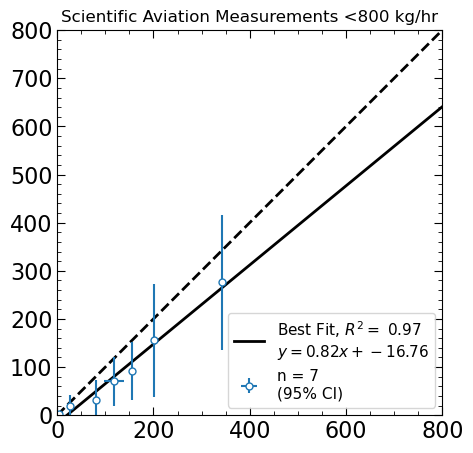

In [47]:
import matplotlib.pyplot as plt
from plot_methods import make_parity_plot, get_parity_data
sciav_data, sciav_notes = get_parity_data('Scientific Aviation', stage=1)

max_release = 800

# Remove data where release rate is > 800 kgh 
sciav_data = sciav_data.loc[sciav_data.release_rate <= max_release].copy()
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
make_parity_plot(sciav_data, sciav_notes, ax, plot_lim=[0, max_release])
ax.set_title('Scientific Aviation Measurements <800 kg/hr')
save_path = pathlib.PurePath('04_figures', '01_paper_figs', f'sci_av_alternative_slope')
plt.savefig(save_path)